In [2]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [30]:
ts = pd.read_csv('takehome_user_engagement.csv')
df = pd.read_csv('takehome_users.csv', encoding='latin-1') 

In [8]:
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [9]:
ts.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
df.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [12]:
df.shape

(12000, 10)

Drop duplicates if there are any.

In [31]:
df.drop_duplicates(['name','email'], keep='first')

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN


Function block to check if users logged in 3 or more times in a single week.

In [18]:
import pandas as pd
from datetime import datetime, timedelta

def find_users_with_multiple_visits(df):
    # Sort the DataFrame by user_id and time_stamp in ascending order
    sorted_df = df.sort_values(by=['user_id', 'time_stamp'])
    
    users_with_multiple_visits = set()
    for i in range(len(sorted_df) - 2):
        # Extract relevant information from the current and next two rows
        current_time = datetime.strptime(sorted_df.iloc[i]['time_stamp'], '%Y-%m-%d %H:%M:%S')
        next_time = datetime.strptime(sorted_df.iloc[i + 1]['time_stamp'], '%Y-%m-%d %H:%M:%S')
        next_next_time = datetime.strptime(sorted_df.iloc[i + 2]['time_stamp'], '%Y-%m-%d %H:%M:%S')
        
        current_user = sorted_df.iloc[i]['user_id']
        next_user = sorted_df.iloc[i + 1]['user_id']
        next_next_user = sorted_df.iloc[i + 2]['user_id']
        
        # Check if the consecutive visits are by the same user and within a week
        if current_user == next_user == next_next_user and \
           next_time - current_time <= timedelta(days=7) and \
           next_next_time - current_time <= timedelta(days=7):
            
            # Record the user_id if they visited 3 or more times within a week
            users_with_multiple_visits.add(current_user)

    return users_with_multiple_visits

result = find_users_with_multiple_visits(ts)
print(result)

{8192, 2, 8196, 8201, 10, 20, 8214, 8217, 8220, 8221, 33, 8232, 8233, 42, 43, 8235, 8239, 50, 8243, 53, 60, 8252, 63, 8255, 8258, 8259, 69, 8265, 74, 8270, 80, 81, 82, 8277, 8278, 87, 8280, 8294, 8297, 8310, 8311, 8319, 133, 135, 141, 8334, 146, 153, 8348, 160, 165, 168, 172, 174, 8366, 8371, 185, 188, 8381, 8383, 197, 200, 8393, 202, 203, 8394, 8399, 209, 8401, 8403, 214, 8408, 8415, 230, 8426, 8435, 245, 247, 8440, 8442, 8448, 263, 265, 8460, 8463, 8466, 275, 280, 283, 297, 298, 8493, 305, 310, 311, 8505, 8507, 8508, 8511, 321, 322, 8523, 341, 345, 8538, 347, 351, 8553, 362, 363, 370, 8569, 8571, 383, 8581, 397, 401, 8593, 8595, 8601, 8602, 418, 8615, 430, 8622, 445, 8639, 8640, 450, 460, 462, 8654, 469, 471, 472, 478, 479, 8673, 483, 8675, 8677, 8679, 492, 494, 497, 8689, 502, 8695, 506, 509, 510, 8701, 512, 8704, 8706, 8708, 518, 520, 8712, 522, 529, 8721, 8725, 535, 540, 547, 8740, 8741, 553, 8749, 8750, 564, 8760, 572, 8767, 8768, 8769, 8770, 8779, 589, 591, 8789, 8790, 601, 603,

For adopted users assign a value 1 for others assign 0.

In [32]:
df['adopted_user'] = df['object_id'].apply(lambda x: 1 if x in result else 0)

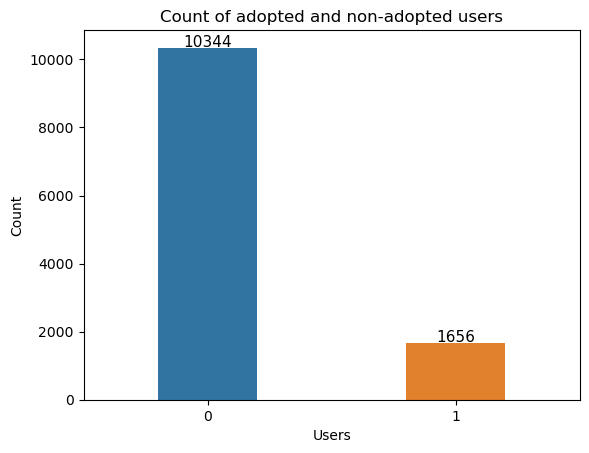

In [109]:
x = df.groupby('adopted_user').agg(total=('adopted_user','size')).reset_index()
ax = sns.barplot(data=x, x=x.adopted_user, y=x.total, width=0.4)
plt.title('Count of adopted and non-adopted users')
ax.set(xlabel='Users', ylabel='Count')
for i, v in enumerate(x.total):
    ax.text(i, v + 40, str(v), ha='center', fontsize=11)

Encode the values of creation_source column for modeling process.

In [34]:
dummies = pd.get_dummies(df.creation_source, drop_first=True)
df1 = pd.concat([df,dummies], axis=1)
df1.drop('creation_source',axis=1,inplace=True)

In [ ]:
# Convert the 'creation_time' column to pandas datetime object
df['creation_time'] = pd.to_datetime(df['creation_time'])

# Calculate the age in days
current_time = datetime.now()
df['account_age'] = (current_time - df['creation_time']).dt.days

In [39]:
X = df1.drop(['name','email','adopted_user','invited_by_user_id','last_session_creation_time','creation_time'], axis=1)
y = df1.adopted_user

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [69]:
# evluation of the model
model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy of test set was', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of test set was 0.836
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      2580
           1       0.18      0.05      0.08       420

    accuracy                           0.84      3000
   macro avg       0.52      0.51      0.49      3000
weighted avg       0.77      0.84      0.79      3000



In [70]:
confusion_matrix(y_test,y_pred)

array([[2488,   92],
       [ 400,   20]], dtype=int64)

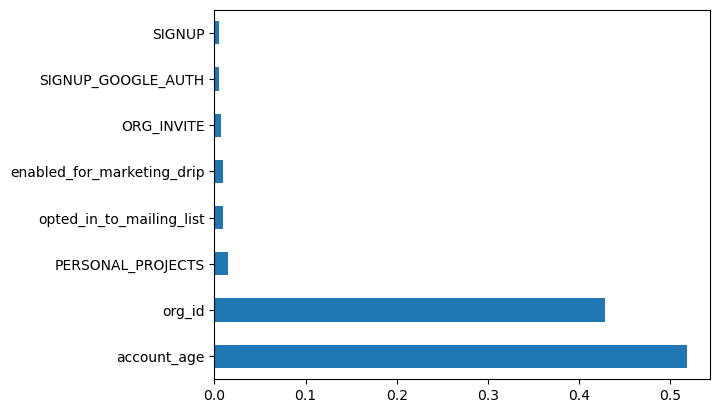

opted_in_to_mailing_list      0.009935
enabled_for_marketing_drip    0.009783
org_id                        0.428532
account_age                   0.518021
ORG_INVITE                    0.007698
PERSONAL_PROJECTS             0.015479
SIGNUP                        0.005108
SIGNUP_GOOGLE_AUTH            0.005444
dtype: float64


In [111]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
print(feat_importances)

It appers that the organization (group of users) they belong to and the account age has importance.